In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [1]:
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob

In [2]:
images_path = '../input/archive/flickr8k-sau/Flickr_Data/Images/'
images = glob(images_path+'*.jpg')
len(images)

8091

In [3]:
images[:5]

['../input/archive/flickr8k-sau/Flickr_Data/Images/3226254560_2f8ac147ea.jpg',
 '../input/archive/flickr8k-sau/Flickr_Data/Images/214543992_ce6c0d9f9b.jpg',
 '../input/archive/flickr8k-sau/Flickr_Data/Images/2366643786_9c9a830db8.jpg',
 '../input/archive/flickr8k-sau/Flickr_Data/Images/3368819708_0bfa0808f8.jpg',
 '../input/archive/flickr8k-sau/Flickr_Data/Images/2190227737_6e0bde2623.jpg']

In [4]:
from keras.applications import ResNet50

incept_model = ResNet50(include_top=True)

102973440/102967424 [==============================] - 1s 0us/step


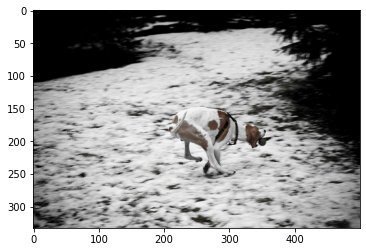

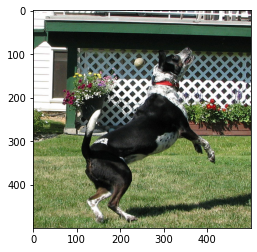

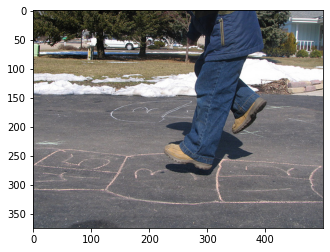

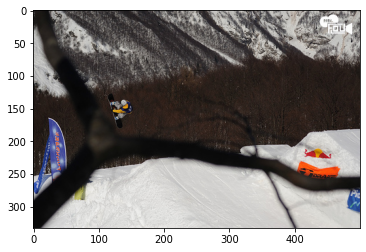

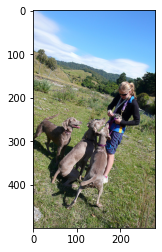

In [5]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

In [6]:
from keras.models import Model
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = modele.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 1499:
        break
        
    elif count % 50 == 0:
        print(count)
    

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450


In [8]:
len(images_features)

1500

In [13]:
caption_path = '../input/archive/flickr8k-sau/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [14]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [15]:
len(captions)

40461

In [16]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split('\t')[0][:-2] 
        caption = i.split('\t')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
            
    except:
        pass

In [17]:
len(captions_dict)

1500

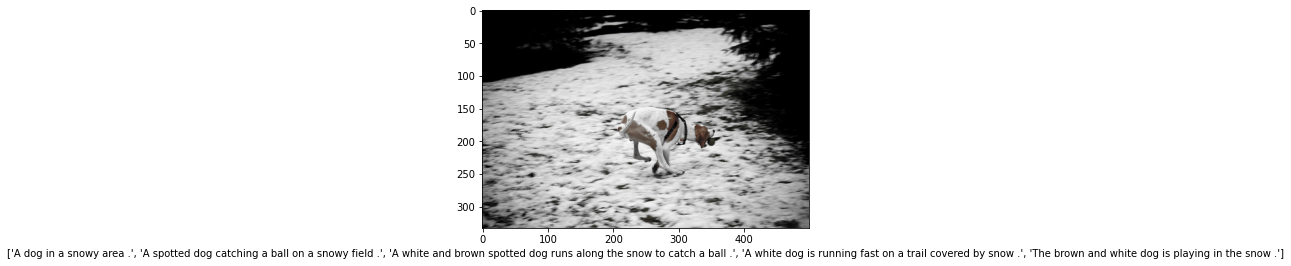

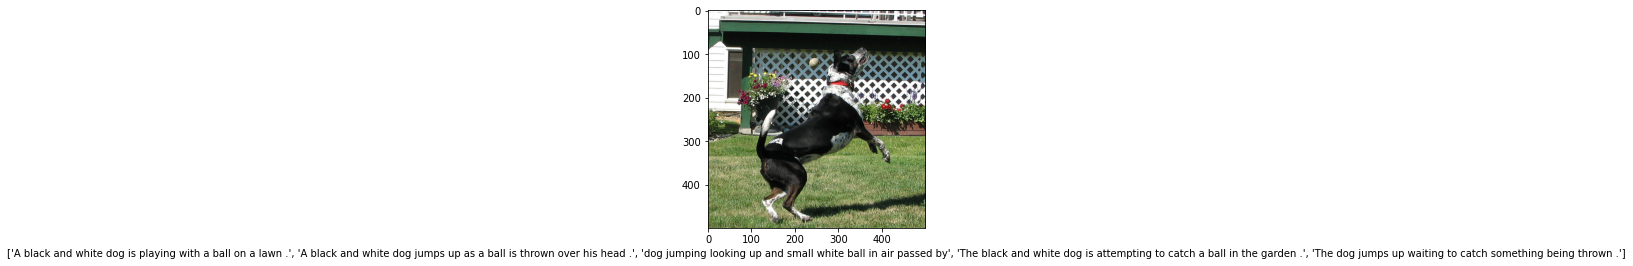

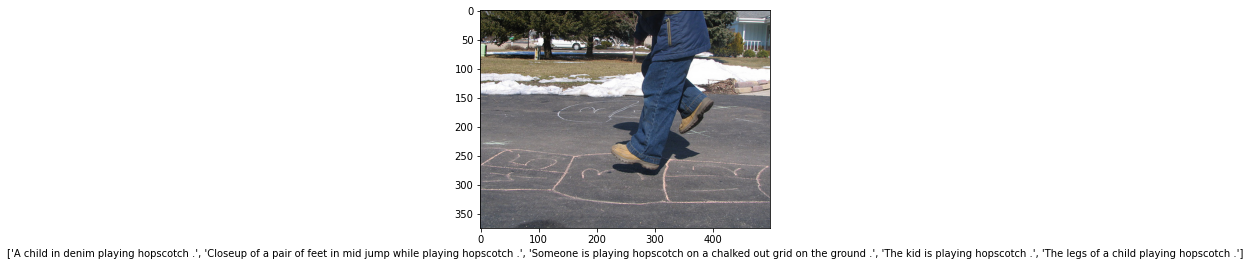

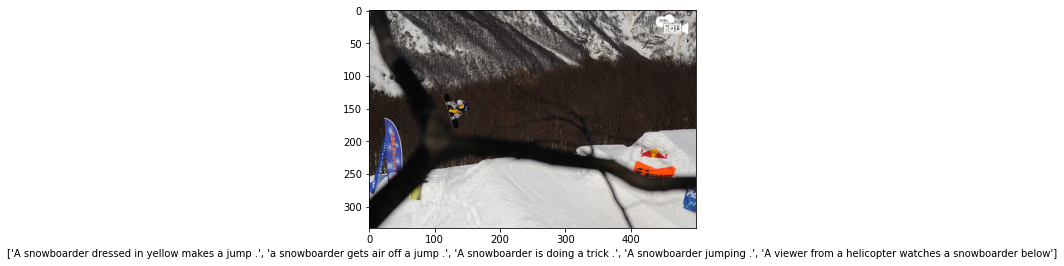

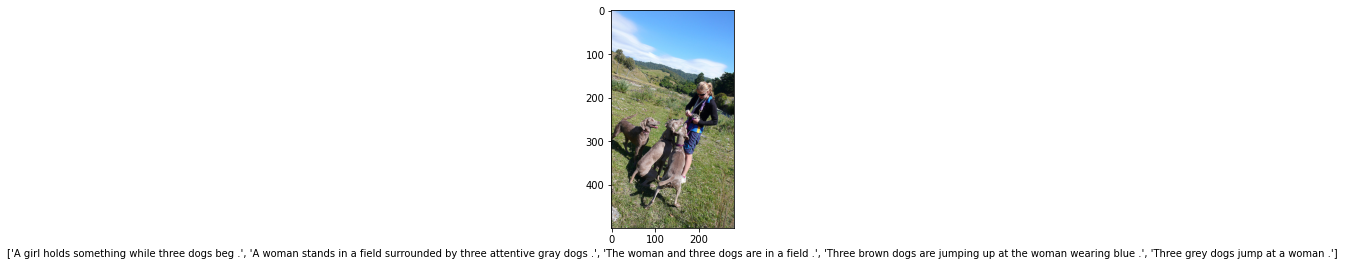

In [18]:
import matplotlib.pyplot as plt

for i in range(5):
    plt.figure()
    img_name = images[i]
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)

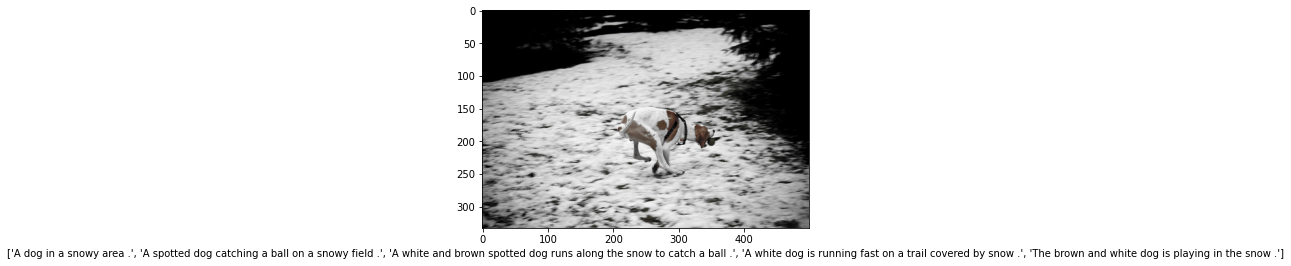

In [20]:
import matplotlib.pyplot as plt

for k in images_features.keys():
    plt.figure()
    
    img_name = '../input/archive/flickr8k-sau/Flickr_Data/Images/' + k
    
    
    img = cv2.imread(img_name)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.xlabel(captions_dict[img_name.split('/')[-1]])
    plt.imshow(img)
    
    break

In [21]:
def preprocessed(txt):
    modified = txt.lower()
    modified = 'startofseq ' + modified + ' endofseq'
    return modified
    

In [22]:
for k,v in captions_dict.items():
    for vv in v:
        captions_dict[k][v.index(vv)] = preprocessed(vv)

In [23]:
count_words = {}
for k,vv in captions_dict.items():
    for v in vv:
        for word in v.split():
            if word not in count_words:

                count_words[word] = 0

            else:
                count_words[word] += 1

In [24]:
len(count_words)

4073

In [25]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
    if count_words[k] > THRESH:
        new_dict[k] = count
        count += 1
        

In [26]:
len(new_dict)

4073

In [27]:
new_dict['<OUT>'] = len(new_dict) 

In [28]:
captions_backup = captions_dict.copy()

In [29]:
captions_dict = captions_backup.copy()

In [30]:
for k, vv in captions_dict.items():
    for v in vv:
        encoded = []
        for word in v.split():  
            if word not in new_dict:
                encoded.append(new_dict['<OUT>'])
            else:
                encoded.append(new_dict[word])


        captions_dict[k][vv.index(v)] = encoded

In [31]:
captions_dict

{'1002674143_1b742ab4b8.jpg': [[1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   6,
   9,
   10,
   2,
   11,
   12,
   13,
   14,
   15,
   6,
   2,
   16,
   17,
   18],
  [1, 2, 3, 4, 19, 20, 6, 9, 10, 2, 21, 11, 12, 17, 18],
  [1,
   2,
   22,
   4,
   6,
   23,
   24,
   25,
   13,
   26,
   6,
   9,
   10,
   2,
   27,
   28,
   13,
   2,
   12,
   29,
   30,
   17,
   18],
  [1, 31, 19, 2, 4, 13, 32, 20, 6, 9, 10, 2, 12, 33, 17, 18],
  [1, 34, 4, 13, 32, 33, 35, 6, 23, 24, 17, 18]],
 '102351840_323e3de834.jpg': [[1, 2, 36, 37, 2, 38, 6, 23, 39, 17, 18],
  [1, 2, 36, 19, 37, 40, 23, 41, 39, 10, 2, 42, 17, 18],
  [1, 2, 43, 6, 23, 44, 37, 2, 38, 6, 23, 39, 17, 18],
  [1, 2, 43, 45, 29, 2, 41, 46, 17, 18],
  [1, 47, 48, 49, 39, 50, 17, 18]],
 '1024138940_f1fefbdce1.jpg': [[1,
   47,
   51,
   52,
   10,
   53,
   54,
   27,
   55,
   56,
   29,
   23,
   57,
   17,
   18],
  [1, 47, 55, 49, 58, 2, 59, 29, 2, 60, 61, 57, 17, 18],
  [1, 47, 55, 62, 6, 23, 61, 63, 23, 57, 17, 18],
  [1

In [36]:
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences


In [37]:
MAX_LEN = 0
for k, vv in captions_dict.items():
    for v in vv:
        if len(v) > MAX_LEN:
            MAX_LEN = len(v)
            print(v)

[1, 2, 3, 4, 5, 6, 7, 8, 6, 9, 10, 2, 11, 12, 13, 14, 15, 6, 2, 16, 17, 18]
[1, 2, 22, 4, 6, 23, 24, 25, 13, 26, 6, 9, 10, 2, 27, 28, 13, 2, 12, 29, 30, 17, 18]
[1, 2, 180, 190, 6, 2, 77, 191, 54, 77, 192, 193, 2, 53, 194, 121, 2, 41, 46, 54, 195, 196, 17, 18]
[1, 23, 131, 6, 23, 77, 122, 19, 706, 2, 700, 701, 467, 2, 128, 265, 23, 131, 6, 23, 245, 385, 707, 73, 621, 151, 93, 17, 18]
[1, 23, 47, 34, 178, 49, 6, 126, 54, 27, 1049, 54, 1050, 318, 281, 6, 2, 1051, 81, 322, 49, 69, 1052, 279, 2, 36, 1053, 6, 1049, 54, 2, 364, 18]
[1, 318, 188, 27, 205, 19, 35, 23, 156, 81, 472, 27, 205, 13, 2, 126, 2264, 29, 442, 298, 19, 149, 83, 2, 626, 465, 156, 318, 147, 567, 279, 2, 523, 1103, 17, 18]


In [38]:
MAX_LEN

36

In [39]:
captions_dict

{'1002674143_1b742ab4b8.jpg': [[1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   6,
   9,
   10,
   2,
   11,
   12,
   13,
   14,
   15,
   6,
   2,
   16,
   17,
   18],
  [1, 2, 3, 4, 19, 20, 6, 9, 10, 2, 21, 11, 12, 17, 18],
  [1,
   2,
   22,
   4,
   6,
   23,
   24,
   25,
   13,
   26,
   6,
   9,
   10,
   2,
   27,
   28,
   13,
   2,
   12,
   29,
   30,
   17,
   18],
  [1, 31, 19, 2, 4, 13, 32, 20, 6, 9, 10, 2, 12, 33, 17, 18],
  [1, 34, 4, 13, 32, 33, 35, 6, 23, 24, 17, 18]],
 '102351840_323e3de834.jpg': [[1, 2, 36, 37, 2, 38, 6, 23, 39, 17, 18],
  [1, 2, 36, 19, 37, 40, 23, 41, 39, 10, 2, 42, 17, 18],
  [1, 2, 43, 6, 23, 44, 37, 2, 38, 6, 23, 39, 17, 18],
  [1, 2, 43, 45, 29, 2, 41, 46, 17, 18],
  [1, 47, 48, 49, 39, 50, 17, 18]],
 '1024138940_f1fefbdce1.jpg': [[1,
   47,
   51,
   52,
   10,
   53,
   54,
   27,
   55,
   56,
   29,
   23,
   57,
   17,
   18],
  [1, 47, 55, 49, 58, 2, 59, 29, 2, 60, 61, 57, 17, 18],
  [1, 47, 55, 62, 6, 23, 61, 63, 23, 57, 17, 18],
  [1

In [40]:
Batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
    n_samples = 0
    
    X = []
    y_in = []
    y_out = []
    
    for k, vv in caption.items():
        for v in vv:
            for i in range(1, len(v)):
                X.append(photo[k])

                in_seq= [v[:i]]
                out_seq = v[i]

                in_seq = pad_sequences(in_seq, maxlen=MAX_LEN, padding='post', truncating='post')[0]
                out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

                y_in.append(in_seq)
                y_out.append(out_seq)
            
    return X, y_in, y_out
    

In [41]:
X, y_in, y_out = generator(images_features, captions_dict)

In [42]:
len(X), len(y_in), len(y_out)

(96528, 96528, 96528)

In [43]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

In [44]:
X.shape, y_in.shape, y_out.shape

((96528, 2048), (96528, 36), (96528, 4074))

In [45]:
X[1510]

array([1.4754434 , 0.21838042, 0.14905131, ..., 1.4680874 , 0.660953  ,
       0.        ], dtype=float32)

In [46]:
y_in[2]

array([1., 2., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.])

In [47]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

In [48]:
embedding_size = 128
max_len = MAX_LEN
vocab_size = len(new_dict)

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 36, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 36, 128)           521472    
_________________________________________________________________
lstm (LSTM)                  (None, 36, 256)           394240    
_________________________________________________________________
time_distributed (TimeDistri (None, 36, 128)           32896     
Total params: 948,608
Traina

In [49]:
model.fit([X, y_in], y_out, batch_size=512, epochs=50)

Epoch 1/50
189/189 [==============================] - 17s 66ms/step - loss: 5.4952 - accuracy: 0.1126
Epoch 2/50
189/189 [==============================] - 12s 66ms/step - loss: 4.8049 - accuracy: 0.1862
Epoch 3/50
189/189 [==============================] - 12s 66ms/step - loss: 4.4447 - accuracy: 0.2452
Epoch 4/50
189/189 [==============================] - 13s 66ms/step - loss: 4.2749 - accuracy: 0.2616
Epoch 5/50
189/189 [==============================] - 12s 66ms/step - loss: 4.1572 - accuracy: 0.2704
Epoch 6/50
189/189 [==============================] - 12s 66ms/step - loss: 4.0342 - accuracy: 0.2813
Epoch 7/50
189/189 [==============================] - 12s 66ms/step - loss: 3.8553 - accuracy: 0.3001
Epoch 8/50
189/189 [==============================] - 12s 66ms/step - loss: 3.6761 - accuracy: 0.3177
Epoch 9/50
189/189 [==============================] - 12s 66ms/step - loss: 3.5086 - accuracy: 0.3352
Epoch 10/50
189/189 [==============================] - 12s 65ms/step - loss: 3.382

In [61]:
inv_dict = {v:k for k, v in new_dict.items()}

In [62]:
model.save('model.h5')

In [63]:
model.save_weights('mine_model_weights.h5')

In [64]:
np.save('vocab.npy', new_dict)

In [65]:
def getImage(x):
    
    test_img_path = images[x]

    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    test_img = cv2.resize(test_img, (224,224))

    test_img = np.reshape(test_img, (1,224,224,3))
    
    return test_img

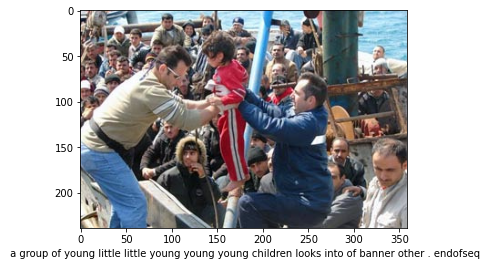

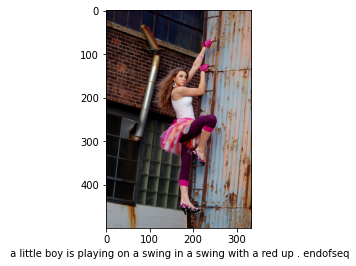

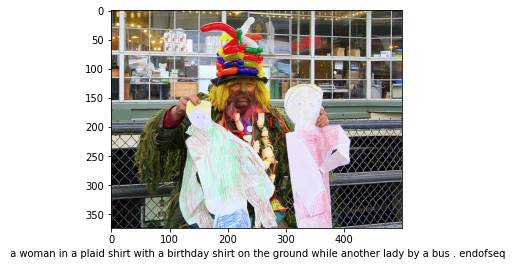

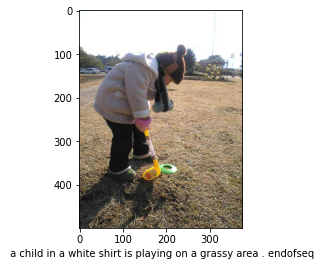

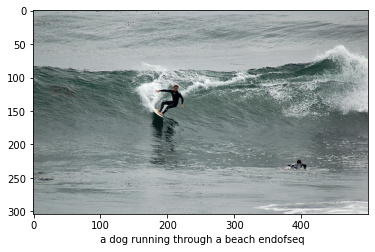

In [66]:
for i in range(5):
    
    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)
    
    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)


    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=MAX_LEN)


        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word
            
        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)
        
    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)